In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False  
# set false once done training data

In [2]:
class MenVsWomen():
    IMG_SIZE = 50
    MEN = "data/men"
    WOMEN = "data/women"
    TESTING = "data/Testing"
    LABELS = {MEN: 0, WOMEN: 1}
    training_data = []

    Mencount = 0
    Womencount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.MEN:
                            self.Mencount += 1
                        elif label == self.WOMEN:
                            self.Womencount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Men:',MenVsWomen.Mencount)
        print('Women:',MenVsWomen.Womencount)

if REBUILD_DATA:
    menVwomen = MenVsWomen()
    menVwomen.make_training_data()

  0%|          | 0/1418 [00:00<?, ?it/s]

data/men


  0%|          | 3/1584 [00:00<01:08, 23.14it/s]

data/women


100%|██████████| 1584/1584 [00:51<00:00, 30.90it/s]


Men: 0
Women: 0


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
print(len(training_data))

2703


In [5]:
print(training_data[1])

[array([[102, 104,  85, ...,  89,  88, 110],
       [102,  99,  87, ...,  88,  83, 105],
       [ 98, 110, 106, ...,  88,  91, 101],
       ...,
       [101,  74, 136, ...,  98,  81, 215],
       [ 74,  86, 118, ...,  89,  80, 130],
       [124,  81, 117, ...,  95,  81, 186]], dtype=uint8)
 array([0., 1.])]


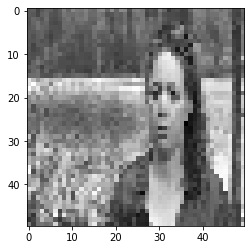

In [6]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [7]:
training_data[1][1]

array([0., 1.])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

torch.Size([128, 2, 2])


In [10]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

x = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
x = x/255.0
y = torch.Tensor([i[1] for i in training_data])

# validation size is 10%
VAL_PCT = 0.1
val_size = int(len(x)*VAL_PCT)
print(val_size)


270


In [11]:
train_x = x[:-val_size]
train_y = y[:-val_size]

test_x = x[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(test_x))



2433
270


In [22]:
BATCH_SIZE = 100
EPOCHS = 8

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        
        #print(i, i+BATCH_SIZE)
        batch_x = train_x[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}. Loss: {loss}")

        


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  4%|▍         | 1/25 [00:00<00:08,  2.78it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:01<00:07,  2.95it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:06,  3.04it/s]

torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  3.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:05,  3.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  2.89it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 9/25 [00:03<00:05,  2.78it/s]

torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:05,  2.67it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 12/25 [00:04<00:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:04,  2.75it/s]

torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:05<00:03,  2.74it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:03,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  2.87it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:01,  3.06it/s]

torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  3.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:07<00:01,  2.85it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.95it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  2.80it/s]

torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 0. Loss: 7.322414603549987e-06
torch.Size([128, 2, 2])


  4%|▍         | 1/25 [00:00<00:07,  3.14it/s]

torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:07,  3.15it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:01<00:07,  2.95it/s]

torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  3.12it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:01<00:05,  3.21it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:05,  3.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  3.04it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 9/25 [00:02<00:05,  3.11it/s]

torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:04,  3.14it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  3.09it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:04,  2.87it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 14/25 [00:04<00:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:02,  3.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  3.02it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:01,  3.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  3.08it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:06<00:01,  3.06it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  2.90it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 24/25 [00:07<00:00,  3.00it/s]

torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 1. Loss: 6.079676040826598e-06
torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:07,  3.16it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:00<00:07,  3.13it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:06,  3.07it/s]

torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  3.03it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:01<00:06,  3.09it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:05,  3.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 9/25 [00:03<00:05,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  2.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 12/25 [00:04<00:04,  2.80it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:04,  2.86it/s]

torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:05<00:03,  2.97it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:02,  3.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  2.95it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 18/25 [00:06<00:02,  3.01it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:02,  2.99it/s]

torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  2.92it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.87it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  2.97it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 24/25 [00:08<00:00,  3.07it/s]

torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 2. Loss: 4.762296612170758e-06
torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:08,  2.86it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:01<00:07,  2.89it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:07,  2.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  2.87it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:06,  2.91it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  2.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:04,  3.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  3.04it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:03,  3.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 14/25 [00:04<00:04,  2.61it/s]

torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:05<00:03,  2.65it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:03,  2.78it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  2.81it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 18/25 [00:06<00:02,  2.80it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:02,  2.69it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:07<00:01,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.95it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  2.87it/s]

torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 3. Loss: 5.139287168276496e-06
torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:08,  2.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:07,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:02<00:06,  2.86it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:06,  2.87it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  2.96it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 9/25 [00:03<00:05,  2.96it/s]

torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:04,  3.04it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  3.07it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 12/25 [00:03<00:04,  3.11it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:03,  3.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 14/25 [00:04<00:03,  2.95it/s]

torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:05<00:03,  3.00it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:02,  3.04it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  3.04it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:02,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  2.90it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.98it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  3.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 4. Loss: 5.122343281982467e-06


  4%|▍         | 1/25 [00:00<00:08,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:01<00:07,  2.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  3.08it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:01<00:06,  3.12it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:05,  3.15it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  3.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:05,  2.98it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  3.05it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 12/25 [00:03<00:04,  3.10it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:03,  3.13it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 14/25 [00:04<00:03,  3.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:04<00:03,  2.98it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:03,  2.79it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  2.86it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:01,  3.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  3.05it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:07<00:01,  2.77it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.79it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 24/25 [00:08<00:00,  3.00it/s]

torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 5. Loss: 4.986009571439354e-06


  4%|▍         | 1/25 [00:00<00:08,  2.75it/s]

torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:08,  2.81it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:01<00:07,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:07,  2.91it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:02<00:06,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 7/25 [00:02<00:06,  2.94it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 9/25 [00:03<00:05,  3.06it/s]

torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:04,  3.10it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:04,  3.14it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 12/25 [00:03<00:04,  3.16it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:03,  3.11it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 14/25 [00:04<00:03,  3.02it/s]

torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:04<00:03,  3.08it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:02,  3.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  3.06it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 18/25 [00:05<00:02,  3.10it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:01,  3.11it/s]

torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  2.72it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:07<00:01,  2.83it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 23/25 [00:07<00:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
Epoch: 6. Loss: 4.624509074346861e-06
torch.Size([128, 2, 2])


  8%|▊         | 2/25 [00:00<00:07,  3.13it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 3/25 [00:00<00:06,  3.15it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 4/25 [00:01<00:06,  3.08it/s]

torch.Size([128, 2, 2])


 20%|██        | 5/25 [00:01<00:06,  3.10it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 6/25 [00:01<00:06,  3.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 8/25 [00:02<00:05,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 10/25 [00:03<00:05,  2.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 11/25 [00:03<00:05,  2.58it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 13/25 [00:04<00:04,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 15/25 [00:05<00:03,  2.93it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 16/25 [00:05<00:03,  3.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 17/25 [00:05<00:02,  2.84it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 18/25 [00:06<00:02,  2.93it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 19/25 [00:06<00:02,  2.83it/s]

torch.Size([128, 2, 2])


 80%|████████  | 20/25 [00:06<00:01,  2.66it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 21/25 [00:07<00:01,  2.50it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 22/25 [00:07<00:01,  2.48it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 24/25 [00:08<00:00,  2.59it/s]

torch.Size([128, 2, 2])


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]

torch.Size([128, 2, 2])
Epoch: 7. Loss: 4.384420662972843e-06


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct +=1
        total +=1
print("Accuracy:", round(correct/total, 3))

 20%|█▉        | 53/270 [00:00<00:00, 227.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 31%|███       | 83/270 [00:00<00:00, 243.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 55%|█████▌    | 149/270 [00:00<00:00, 279.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 79%|███████▉  | 213/270 [00:00<00:00, 280.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 270/270 [00:00<00:00, 297.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy: 0.707
